In [18]:
import os
import numpy as np
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

In [19]:
# === PARAMETERS ===
SCRIPT_PATH = os.getcwd()
INPUT_DIR = os.path.join(SCRIPT_PATH, '../data', 'preprocessed', 'neural_network')
OUTPUT_DIR = os.path.join(SCRIPT_PATH, '../models')

In [20]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# === LOAD PREPROCESSED DATA ===
print("Ładowanie danych...")
train_data = np.load(os.path.join(INPUT_DIR, 'train.npz'))
X_train = train_data['X']
y_train = train_data['y']

val_data = np.load(os.path.join(INPUT_DIR, 'val.npz'))
X_val = val_data['X']
y_val = val_data['y']

test_data = np.load(os.path.join(INPUT_DIR, 'test.npz'))
X_test = test_data['X']
y_test = test_data['y']

# Load label encoder
label_encoder = joblib.load(os.path.join(INPUT_DIR, 'label_encoder.pkl'))
target_names = label_encoder.classes_

Ładowanie danych...


In [21]:
# === Combining Validation and test sets ===
X_test = np.concatenate((X_test, X_val), axis=0)
y_test = np.concatenate((y_test, y_val), axis=0)

In [22]:
# === TRAIN HIDDEN MARKOV MODEL ===
unique_labels = np.unique(y_train)
models = {}
for label in unique_labels:
    class_mask = (y_train == label)
    X_class = X_train[class_mask]

    N_samples = X_class.shape[0]
    X_hmm_format = X_class.reshape(-1, 2)
    lengths = [100] * N_samples
    print(f"Training HMM for class: {label_encoder.inverse_transform([label])[0]}...")

    model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=20, random_state=42)
    model.fit(X_hmm_format, lengths=lengths)

    models[label] = model

# === EVALUATE THE MODEL ===
y_pred = []

for i in range(len(X_test)):
    sequence = X_test[i]

    best_score = -np.inf
    best_label = None

    for label, model in models.items():
        try:
            score = model.score(sequence)
            if score > best_score:
                best_score = score
                best_label = label
        except:
            pass #

    y_pred.append(best_label)

Trenowanie modelu HMM dla klasy: faulty...
Trenowanie modelu HMM dla klasy: faulty_zip...
Trenowanie modelu HMM dla klasy: healthy...
Trenowanie modelu HMM dla klasy: healthy_zip...



Accuracy: 0.8155283389951725

Classification Report:
               precision    recall  f1-score   support

      faulty       0.90      0.95      0.93     11186
  faulty_zip       0.95      0.89      0.92     11186
     healthy       0.68      0.78      0.73     11186
 healthy_zip       0.74      0.63      0.68     11186

    accuracy                           0.82     44744
   macro avg       0.82      0.82      0.81     44744
weighted avg       0.82      0.82      0.81     44744



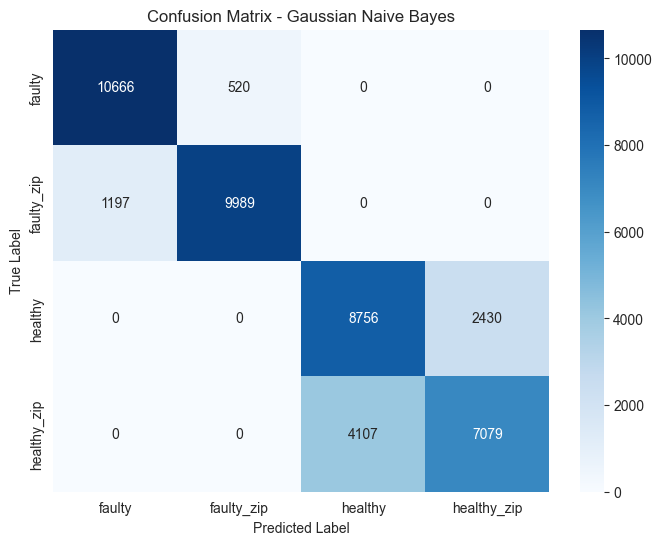

Model zapisano w: C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models_code\../models\gaussian_nb_model.pkl


In [24]:
# Metrics
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# === SAVE THE MODEL ===
model_path = os.path.join(OUTPUT_DIR, 'gaussian_nb_model.pkl')
joblib.dump(model, model_path)
print(f"Model zapisano w: {model_path}")